# Investigating adjusted p-values from 0ppm vs 625ppm eQTL analysis

__Author:__ Bryan Quach  
__Date:__ April 28, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney. The phenotype was the normalized expression differences between 625ppm and 0ppm BD treated CC mice.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [1]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/0ppm_vs_625ppm_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/0ppm_vs_625ppm_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/0ppm_vs_625ppm_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mg

## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [2]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

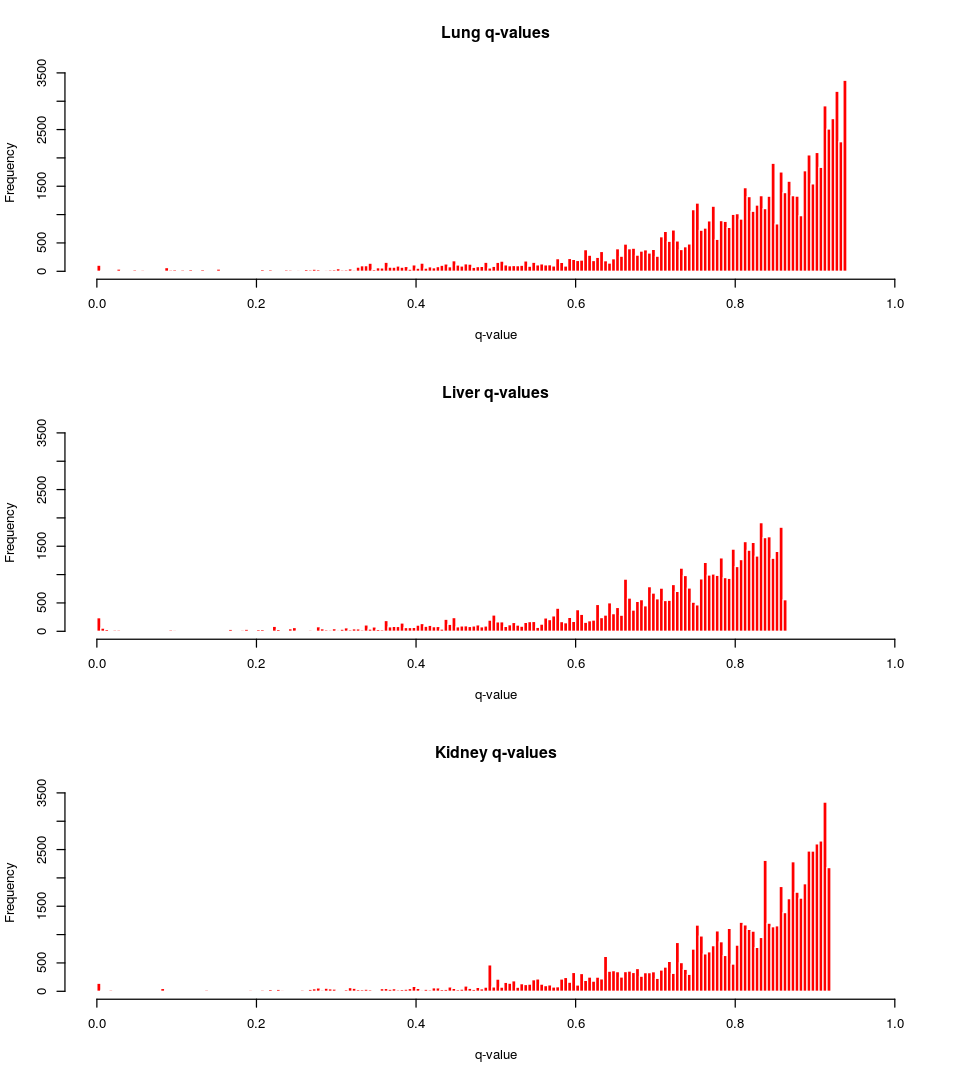

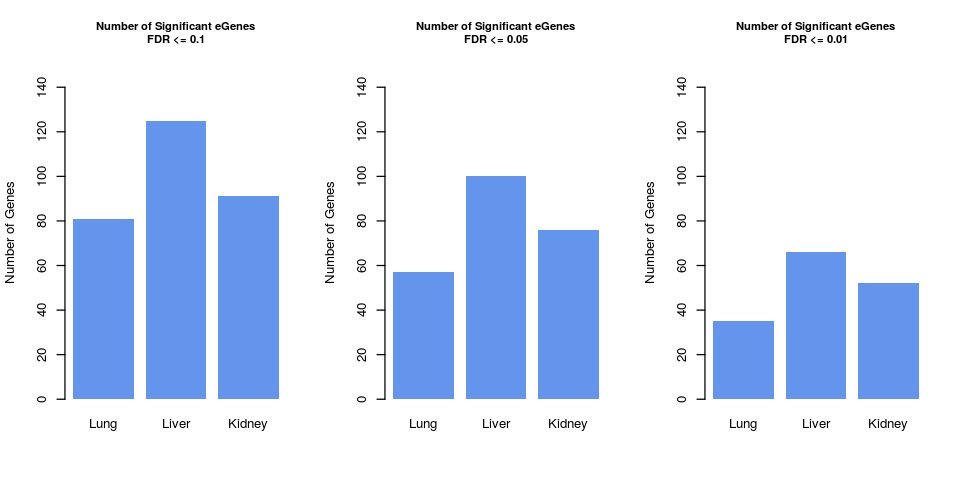

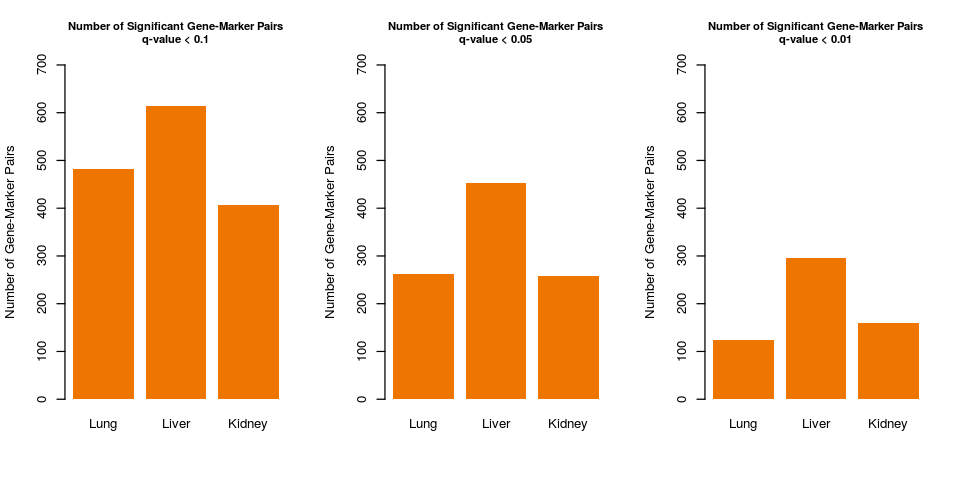

In [3]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,150),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,150),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,150),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,700),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,700),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,700),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [4]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/0ppm_vs_625ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/0ppm_vs_625ppm_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/0ppm_vs_625ppm_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene          marker                         chr   start     end      
36945 Dcps          UNC16139398.JAX00689916        chr9  34191620  34635092 
3688  Marc1         UNC2343495.JAX00278921         chr1  185628817 185819669
3696  Marc1         UNC2345938.JAX00278925         chr1  185820574 185827839
3704  Marc1         UNC2346376.UNC2347788          chr1  185844865 186038248
3716  Marc1         UNC2348110.UNC2349761          chr1  186060887 186196496
14290 Ttc22         UNC7905375.UNC040215368        chr4  105050114 105593993
14311 Ttc22         UNC7913411.UNC7928876          chr4  105636559 106692080
14335 Ttc22         JAX00122955.UNC7931463         chr4  106754201 106907260
14359 Ttc22         JAX00561354.JAX00561354        chr4  106991042 106991042
14394 Ttc22         UNC7932936.UNC7947729          chr4  107007905 108092055
37189 Oaf           JAX00691903.UNC16275832        chr9  42757738  44638946 
3765  Marc1         UNC2352059.UNC2363161          chr1  186434532 187309167
3780  Marc1         UNC2363410.UNC2365651          chr1  187323801 187464761
37156 Oaf           UNC16230132.UNC16253527        chr9  41188870  42755217 
10587 2810403A07Rik UNC5722551.backupJAX00110129   chr3  87571343  88658464 
10481 2810403A07Rik UNC5682922.UNC5721856          chr3  84361339  87495006 
10672 2810403A07Rik UNC5732520.UNC5752814          chr3  88658882  91515928 
33822 Stox2         UNC14668571.UNC14672107        chr8  48187506  48416373 
33836 Stox2         JAX00667796.JAX00161517        chr8  48419949  48848138 
33844 Stox2         UNC14679166.UNC_rs49846602     chr8  48867711  49118856 
33852 Stox2         UNC14682899.JAX00668007        chr8  49142445  49378958 
33860 Stox2         UNC14686674.UNC14692700        chr8  49381104  49791008 
67670 Riok3         UNC28702402.UNC181063332       chr18 9273321   11988056 
52758 Serpina3h     UNC21786436.UNC21786664        chr12 105226225 105246146
914   Adam23        UNC790025.UNC791840            chr1  62671648  62831748 
925   Adam23        UNC792051.UNC795596            chr1  62854647  63187180 
938   Adam23        UNC_rs31392164.UNC802071       chr1  63191335  63853771 
52754 Serpina1e     UNC21786436.UNC21786664        chr12 105226225 105246146
55767 Gm3383        JAX00049708.JAX00372110        chr14 3262706   7761299  
10542 2810403A07Rik backupUNC030491543.UNC5722547  chr3  87526958  87570981 
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
2935  Nuf2          UNC2158883.UNC2165985          chr1  170716162 171181070
35345 Cmtm4         UNC15422872.UNC15460754        chr8  106893004 110484145
68985 Mc5r          JAX00463560.UNC29521244        chr18 69000900  69357553 
35303 Cmtm4         UNC15417874.UNC15422538        chr8  106499195 106863747
52640 Tc2n          UNC21763677.UNC21772961        chr12 103376309 103988513
35261 Ces2b         UNC15401027.JAX00679070        chr8  105224029 106423866
35276 Ces2b         UNC15416961.JAX00679081        chr8  106429699 106464668
68952 Mc5r          UNC29508829.JAX00084655        chr18 68567294  68685683 
33651 Dlc1          UNC14505600.backupUNC080144868 chr8  37193355  37622126 
68885 Mc5r          UNC29493783.UNC29500011        chr18 67597076  68028832 
26709 Cyp2b13       UNC12514662.JAX00149482        chr7  26273781  27029733 
3817  Rrp15         UNC2373664.UNC2375202          chr1  187985122 188113448
26652 Cyp2b13       UNC12512623.UNC12514434        chr7  26076273  26256213 
68904 Mc5r          UNC29500627.UNC180151602       chr18 68061560  68347140 
68921 Mc5r          UNC29505651.UNC29505806        chr18 68353135  68359457 
3835  Rrp15         JAX00013725.UNC2390835         chr1  189257338 189433862
68937 Mc5r          UNC29506315.UNC29508663        chr18 68385509  68559806 
3840  Rrp15         UNC2390966.JAX00279668         chr1  189444597 189497883
3846  Rrp15         UNC2391711.JAX00279780         chr1  189512282 189889727
26538 Ethe1         backupJAX00633478.UNC12510962  chr7  25582157  25886271 
68

Liver


gene          marker                        chr   start     end      
4168  Pbx3          UNC2845901.UNC2862042         chr2  33101544  34801962 
4202  Pbx3          UNC2862710.UNC2910745         chr2  34844499  40109809 
45686 Ppard         UNC170301400.JAX00434785      chr17 27137922  27483027 
45743 Ppard         UNC27722978.UNC27723391       chr17 27532447  27572669 
45773 Ppard         UNC27723571.UNC27725690       chr17 27595001  27759879 
45715 Ppard         UNC27722618.UNC27722769       chr17 27493965  27513413 
37526 Hist1h2bl     UNC22234794.UNC22263112       chr13 20735950  23717824 
29930 Arhgef25      UNC18933797.JAX00023513       chr10 125160881 126375436
29965 Arhgef25      UNC18954024.UNC18954348       chr10 126377348 126398272
30003 Arhgef25      UNC18954707.UNC18961845       chr10 126429359 127050365
30065 Arhgef25      JAX00302230.UNC18963675       chr10 127068725 127267133
30139 Arhgef25      UNC18963682.JAX00302406       chr10 127267455 127919711
52890 Fhl1          UNC200056198.JAX00712044      chrX  53423342  54475249 
52897 Fhl1          JAX00179390.UNC30852286       chrX  54566224  54860348 
30130 Tspan31       JAX00302230.UNC18963675       chr10 127068725 127267133
30209 Tspan31       UNC18963682.JAX00302406       chr10 127267455 127919711
30056 Tspan31       UNC18954707.UNC18961845       chr10 126429359 127050365
29995 Tspan31       UNC18954024.UNC18954348       chr10 126377348 126398272
29961 Tspan31       UNC18933797.JAX00023513       chr10 125160881 126375436
6243  Mir6340       UNC4536843.UNC4537497         chr2  172975353 173020258
6261  Mir6340       UNC4537733.UNC4540317         chr2  173029622 173171972
6226  Mir6340       UNC4531549.UNC4536733         chr2  172670737 172965050
6280  Mir6340       UNC4540460.UNC4545629         chr2  173176283 173497619
29666 E2f7          UNC18700285.UNC18708909       chr10 109484027 110033340
29675 E2f7          UNC18709522.JAX00298756       chr10 110073611 110199184
29684 E2f7          UNC18711529.UNC18712902       chr10 110199396 110303309
29694 E2f7          JAX00022312.UNC18739738       chr10 110320714 112296191
29658 E2f7          JAX00022117.UNC18699971       chr10 107735938 109461717
52904 Fhl1          JAX00179414.JAX00712149       chrX  54888780  55383196 
45578 Nme4          UNC27694572.UNC27714988       chr17 25154006  26777986 
⋮     ⋮             ⋮                             ⋮     ⋮         ⋮        
29799 Dyrk2         UNC18830967.UNC18835853       chr10 118589334 118989349
29804 Dyrk2         JAX00022960.UNC18837179       chr10 119011646 119049681
29809 Dyrk2         UNC18837573.UNC18838329       chr10 119069320 119111156
29814 Dyrk2         UNC18838853.UNC18839122       chr10 119133040 119156099
29776 Dyrk2         UNC18791150.UNC18820326       chr10 115737387 117993831
45437 Zfp54         JAX00433060.B6_17_023744030_S chr17 19565308  23744030 
4750  Them7         JAX00498115.UNC3707191        chr2  102516691 106556637
29819 Dyrk2         JAX00300302.UNC18847088       chr10 119161171 119604795
16150 Snca          JAX00611384.UNC11243385       chr6  59473011  64689906 
13004 Commd8        JAX00131461.UNC9435145        chr5  71813275  72220669 
13009 Commd8        UNC9435523.UNC9435523         chr5  72260495  72260495 
13000 Commd8        UNC9404380.UNC9430721         chr5  69430572  71678226 
2531  9130409I23Rik UNC2309386.UNC2313844         chr1  182402122 182798117
14528 Rabgef1       UNC10173561.UNC10177662       chr5  131157768 131386889
30055 Tsfm          UNC18954707.UNC18961845       chr10 126429359 127050365
34617 Abca8b        UNC20365061.UNC20370504       chr11 109715729 110017118
34659 Abca8b        UNC20378120.UNC20388460       chr11 110448868 111136321
34632 Abca8b        JAX00031724.JAX00031739       chr11 110023548 110222322
34646 Abca8b        JAX00031740.UNC20377562       chr11 110230687 110415434
13015 Commd8        UNC9435824.JAX00585743        chr5  72300825  73724058 
2551  9130409I23Rik UNC2314414.UNC2329760         chr1

Kidney


gene          marker                         chr   start     end      
24175 Scgb1b29      UNC12581313.JAX00149918        chr7  31886494  33121652 
24188 Scgb1b29      UNC12586775.UNC12586775        chr7  33149026  33149026 
24192 Scgb1b29      UNC070069629.UNC12586965       chr7  33362735  34082037 
24199 Scgb1b29      UNC070070026.UNC070070026      chr7  34170589  34170589 
46312 Mir3069       UNC21810078.UNC21811398        chr12 106706899 106781534
46323 Mir3069       JAX00344525.JAX00344566        chr12 106794881 106875754
46334 Mir3069       UNC21812973.UNC21818364        chr12 106881502 107242467
46343 Mir3069       UNC21818638.backupUNC121237008 chr12 107266798 107347644
35656 Ptprk         UNC17642822.JAX00016147        chr10 27260305  27524374 
35658 Ptprk         UNC17646266.UNC17646266        chr10 27525280  27525280 
46301 Mir3069       UNC21809372.UNC21809878        chr12 106646767 106686715
18290 Zbed5         UNC10173561.UNC10177662        chr5  131157768 131386889
46257 Mir3069       JAX00344333.UNC21802582        chr12 105849517 106183175
46283 Mir3069       UNC21802988.UNC21809010        chr12 106204175 106616738
49719 Lgals3        UNC23970682.UNC23981059        chr14 48797144  49793554 
35660 Ptprk         UNC17646422.UNC17647592        chr10 27547821  27655002 
26598 Pdilt         UNC13709012.UNC13719930        chr7  125456804 126072890
17863 Med13l        UNC10014758.JAX00227731        chr5  119329120 119399083
32543 Apoc3         UNC090071769.UNC16292726       chr9  44926272  45826601 
49711 3632451O06Rik UNC23970682.UNC23981059        chr14 48797144  49793554 
49726 3632451O06Rik UNC23981303.UNC23982070        chr14 49830755  49904420 
32594 Apoc3         UNC16293312.UNC16298943        chr9  45866698  46330505 
49732 3632451O06Rik UNC140178161.UNC23990240       chr14 50027179  50800729 
32613 Apoc3         UNC16299603.UNC16306159        chr9  46374675  46994572 
49750 3632451O06Rik UNC23990985.backupUNC140394528 chr14 50935892  51641939 
49735 Apex1         UNC140178161.UNC23990240       chr14 50027179  50800729 
18580 Stx1a         UNC10247043.UNC10251963        chr5  136258327 136611946
49752 Apex1         UNC23990985.backupUNC140394528 chr14 50935892  51641939 
66229 Chm           backuprs29099122.UNC31218527   chrX  109428265 109761974
18540 Stx1a         UNC10244622.UNC10246662        chr5  136072634 136229777
⋮     ⋮             ⋮                              ⋮     ⋮         ⋮        
37286 Llph          JAX00300388.UNC18847432        chr10 119626713 119626801
37270 Llph          UNC18838853.UNC18839122        chr10 119133040 119156099
37296 Llph          UNC18847502.UNC18855777        chr10 119630606 120269820
37307 Llph          UNC18855865.UNC18857901        chr10 120275904 120449315
30768 Rrad          UNC15417874.UNC15422538        chr8  106499195 106863747
37278 Llph          JAX00300302.UNC18847088        chr10 119161171 119604795
30788 Ces2h         UNC15422872.UNC15460754        chr8  106893004 110484145
56788 Mir5125       UNC170299097.UNC27694074       chr17 23782631  25086028 
37263 Llph          UNC18837573.UNC18838329        chr10 119069320 119111156
37256 Llph          JAX00022960.UNC18837179        chr10 119011646 119049681
30750 Ces2h         UNC15417874.UNC15422538        chr8  106499195 106863747
27253 Cox6a2        UNC13808684.UNC13814587        chr7  134221295 134817666
56991 Rgs11         UNC27715265.UNC27718914        chr17 26794469  27125532 
32629 Apoc3         UNC16306426.UNC16309410        chr9  47025180  47327688 
27338 Cox6a2        UNC13814957.JAX00655598        chr7  134853193 136048583
27404 Cox6a2        UNC13828717.UNC13833115        chr7  136049855 136288311
30723 Rrad          UNC15401027.JAX00679070        chr8  105224029 106423866
59199 Riok3         UNC28702402.UNC181063332       chr18 9273321   11988056 
30739 Rrad          UNC15416961.JAX00679081        chr8  106429699 106464668
27423 Cox6a2        UNC13833491.UNC13836514        chr7  136307967 136470148
35

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [5]:
#Load gene coordinates
tmp.env <- new.env()
load("data/0ppm_vs_625ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes_0_vs_625.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes_0_vs_625.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes_0_vs_625.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate               
Dcps          8.141672e-30 1.296073e-25 chr9:33983571-35983572   
Ttc22         7.577916e-19 6.031642e-15 chr4:105295053-107295054 
Oaf           1.192345e-18 6.326980e-15 chr9:42047898-44047899   
Marc1         2.871485e-18 1.142779e-14 chr1:185635178-187635179 
2810403A07Rik 1.580925e-15 5.033350e-12 chr3:87489715-89489716   
Stox2         3.010446e-14 7.987216e-11 chr8:47437701-49437702   
Riok3         5.179665e-12 1.177930e-08 chr18:11287358-13287359  
Serpina3h     1.366037e-10 2.718243e-07 chr12:104486105-106486106
Adam23        1.973171e-10 3.490101e-07 chr1:62492464-64492465   
Gm3383        5.477613e-10 8.719812e-07 chr14:5743517-7743518    
Tbc1d24       2.215634e-09 3.206425e-06 chr17:23342506-25342507  
Serpina1e     3.696816e-09 4.904134e-06 chr12:104195106-106195107
Hepacam       4.568515e-08 5.594323e-05 chr9:36175190-38175191   
Gm3086        7.757369e-08 8.820682e-05 chr12:70064395-72064396  
Gm4956        8.716870e-08 9.250924e-05 chr1:20288392-22288393   
Mettl7a2      1.318831e-07 1.312155e-04 chr15:99183630-101183631 
Apoa1         2.929845e-07 2.743541e-04 chr9:45036712-47036713   
Ctse          3.133424e-07 2.771165e-04 chr1:132534890-134534891 
Rbm24         4.983421e-07 4.175320e-04 chr13:45513668-47513669  
Gpr83         5.474882e-07 4.357732e-04 chr9:13664653-15664654   
4933424G05Rik 7.550658e-07 5.723759e-04 chr18:14147503-16147504  
Nuf2          9.125476e-07 6.603111e-04 chr1:170461594-172461595 
Mc5r          1.067417e-06 7.387919e-04 chr18:67497256-69497257  
Cmtm4         1.286340e-06 8.503305e-04 chr8:105919706-107919707 
Tc2n          1.335402e-06 8.503305e-04 chr12:101956732-103956733
Ces2b         2.975861e-06 1.822028e-03 chr8:106355543-108355544 
Dlc1          8.665373e-06 5.109040e-03 chr8:37015495-39015496   
Lhfpl3        1.011984e-05 5.753490e-03 chr5:21252010-23252011   
Alms1-ps2     1.054279e-05 5.787264e-03 chr6:84742110-86742111   
S100a4        1.106393e-05 5.870888e-03 chr3:89407691-91407692   
⋮             ⋮            ⋮            ⋮                        
Sirt1         0.0001272117 0.03894392   chr10:61801782-63801783  
Bdkrb2        0.0001476337 0.04434304   chr12:105801381-107801382
Fam181a       0.0001581433 0.04577242   chr12:103553168-105553169
Foxo4         0.0001563141 0.04577242   chrX:97449866-99449867   
Ranbp2        0.0001665780 0.04735277   chr10:56909599-58909600  
6430571L13Rik 0.0001725620 0.04819323   chr9:106242970-108242971 
Pon3          0.0002175370 0.05970639   chr6:4206232-6206233     
Adamdec1      0.0002252064 0.06076373   chr14:68200128-70200129  
Fxyd4         0.0002510762 0.06661469   chr6:116887352-118887353 
Uchl1         0.0002554334 0.06665973   chr5:66067359-68067360   
1700020N18Rik 0.0002617159 0.06719766   chr1:92302605-94302606   
Mir1193       0.0002946417 0.07445082   chr12:109953880-111953881
C530005A16Rik 0.0003079361 0.07659429   chr4:115270234-117270235 
Pappa         0.0003144409 0.07700900   chr4:63785207-65785208   
Cd200r4       0.0003717306 0.08647616   chr16:43820840-45820841  
Cda           0.0003878506 0.08647616   chr4:136923869-138923870 
Gch1          0.0003911228 0.08647616   chr14:46809076-48809077  
Mmp23         0.0003668818 0.08647616   chr4:154027492-155630120 
Prdm2         0.0003835166 0.08647616   chr4:141802611-143802612 
Preb          0.0003861769 0.08647616   chr5:30262699-32262700   
Reck          0.0003648790 0.08647616   chr4:42888401-44888402   
Pfkfb1        0.0004090692 0.08920511   chrX:146024463-148024464 
Mcoln2        0.0004303180 0.09257070   chr3:144812796-146812797 
Akr1b8        0.0004442734 0.09429852   chr6:33304163-35304164   
Bag4          0.0004867780 0.09808885   chr8:25895680-27895681   
Fam171b       0.0004857508 0.09808885   chr2:82652884-84652885   
Gbgt1         0.0004864414 0.09808885   chr2:27352410-29352411   
Mtmr9         0.0004782086 0.09808885   chr14:63162789-65162790  
Gpr89         0.0004950477 0.09850831   chr3:95709220-

Liver


pval          qval         coordinate               
Pbx3          1.609516e-103 1.790265e-99 chr2:33227564-35227565   
Ppard          4.260935e-93 2.369719e-89 chr17:27369698-29369699  
Hist1h2bl      1.190636e-69 4.414480e-66 chr13:20808011-22808012  
Arhgef25       8.045761e-59 2.237325e-55 chr10:125627109-127627110
Fhl1           1.057381e-49 2.352251e-46 chrX:52984937-54984938   
Tspan31        1.655057e-49 3.068200e-46 chr10:125507316-127507317
Mir6340        9.675286e-43 1.537403e-39 chr2:172526648-174526649 
E2f7           2.201470e-33 3.060868e-30 chr10:109182520-111182521
Nme4           1.134058e-26 1.401570e-23 chr17:25232414-27232415  
Gcnt7          1.815683e-25 2.019584e-22 chr2:171284095-173284096 
Rap2c          4.045982e-24 4.091223e-21 chrX:47371194-49371195   
Tbc1d15        7.186100e-22 6.660916e-19 chr10:113688548-115688549
Cs             2.071082e-21 1.772049e-18 chr10:126774782-128774783
Wbscr27        4.215725e-21 3.349394e-18 chr5:134408242-136408243 
G530011O06Rik  1.199125e-20 8.891911e-18 chrX:165416848-166650296 
Slc22a26       2.287805e-18 1.590453e-15 chr19:6877156-8877157    
Zfp790         3.812822e-18 2.494707e-15 chr7:29601090-31601091   
Cebpe          6.525571e-18 4.032440e-15 chr14:54331010-56331011  
Ces2b          9.431997e-18 5.521689e-15 chr8:106355543-108355544 
Ly6g           3.592057e-17 1.997722e-14 chr15:73985690-75985691  
BC024139       4.058759e-15 2.149790e-12 chr15:74956985-76956986  
Gch1           7.953663e-15 4.021300e-12 chr14:46809076-48809077  
Tmem184a       6.643159e-14 3.212689e-11 chr5:139290236-141290237 
Zfp54          2.965677e-11 1.374468e-08 chr17:20560190-22560191  
Them7          3.750514e-11 1.668679e-08 chr2:104064498-106064499 
Dyrk2          1.044550e-10 4.468665e-08 chr10:117305958-119305959
Snca           6.936994e-10 2.857784e-07 chr6:59779848-61779849   
Commd8         3.872997e-09 1.538548e-06 chr5:71559421-73559422   
Rabgef1        1.136366e-08 4.358550e-06 chr5:129647688-131647689 
Tsfm           1.180033e-08 4.375168e-06 chr10:125467869-127467870
⋮             ⋮             ⋮            ⋮                        
Amigo2        0.0003837107  0.04389331   chr15:96077717-98077718  
Ddx56         0.0003867252  0.04389331   chr11:5167731-7167732    
Rab27a        0.0003866557  0.04389331   chr9:71892616-73892617   
Rras          0.0004435516  0.04942326   chr7:51273376-53273377   
Zfp948        0.0004443339  0.04942326   chr17:20704009-22704010  
Fam234a       0.0004557738  0.05019379   chr17:25381186-27381187  
Mterf3        0.0004855791  0.05295193   chr13:66034007-68034008  
Zfp942        0.0005458461  0.05894608   chr17:21099430-23099431  
Upp2          0.0005784186  0.06186298   chr2:57419744-59419745   
Cnot2         0.0005964065  0.06258330   chr10:115018566-117018567
Lyz1          0.0005934209  0.06258330   chr10:115729923-117729924
Usp19         0.0006264932  0.06512602   chr9:107393006-109393007 
Usp16         0.0006333302  0.06522715   chr16:86455229-88455230  
Arglu1        0.0006975820  0.07102840   chr8:7690536-9690537     
Suox          0.0007024296  0.07102840   chr10:127110973-129110974
Ints9         0.0007292310  0.07307420   chr14:64568881-66568882  
Cyp2c37       0.0007485465  0.07434002   chr19:39066913-41066914  
Slc25a10      0.0007801057  0.07678863   chr11:119353150-121353151
Trim43b       0.0008100075  0.07903258   chr9:87987672-89987673   
Mir3473g      0.0008185166  0.07916835   chr2:125728120-127728121 
Susd2         0.0009188978  0.08811121   chr10:74106752-76106753  
Ggnbp1        0.0009318903  0.08859329   chr17:26154979-28154980  
9030025P20Rik 0.0009991436  0.09153793   chr17:14115827-16115828  
Fmo3          0.0009807572  0.09153793   chr1:163914658-165914659 
Gorasp1       0.0010040122  0.09153793   chr9:118846675-120846676 
Imp4          0.0009807013  0.09153793   chr1:33496673-35496674   
Zbed5         0.0009901453  0.09153793   chr5:129371592-131371593 
Casp3         0.0010351737  0.09285675   chr8:46702644-487026

Kidney


pval          qval          coordinate               
Scgb1b29      6.974884e-135 9.686021e-131 chr7:32226559-34226560   
Mir3069        3.242169e-52  2.251200e-48 chr12:105269350-107269351
Ptprk          2.171837e-48  1.005343e-44 chr10:26794625-28794626  
Zbed5          1.195771e-31  4.151418e-28 chr5:129371592-131371593 
Lgals3         7.477730e-30  2.076865e-26 chr14:46993534-48993535  
Pdilt          2.157094e-23  4.992593e-20 chr7:125666995-127666996 
Med13l         5.717473e-18  1.134265e-14 chr5:118010727-120010728 
3632451O06Rik  1.391779e-17  2.147515e-14 chr14:49403041-51403042  
Apoc3          1.264975e-17  2.147515e-14 chr9:45043718-47043719   
Apex1          2.078465e-15  2.886364e-12 chr14:50544623-52544624  
Stx1a          6.401324e-15  8.081380e-12 chr5:134499351-136499352 
Chm            1.177331e-14  1.362466e-11 chrX:109299123-111299124 
Rbpj           2.319090e-14  2.477323e-11 chr5:52947017-54947018   
Bace1          4.790055e-14  4.751392e-11 chr9:44646627-46646628   
Gm14288        5.316849e-14  4.922339e-11 chr2:174100624-176100625 
Hcfc1r1        1.388575e-13  1.205196e-10 chr17:22810574-24810575  
Mir6954        1.488332e-13  1.215792e-10 chr15:75263643-77263644  
Cmtm3          1.093745e-12  8.438240e-10 chr8:105864493-107864494 
Lynx1          5.878748e-12  4.296746e-09 chr15:73583408-75583409  
Peg13          3.038176e-11  2.109558e-08 chr15:71640753-73640754  
1700001J03Rik  4.641764e-11  3.069532e-08 chr5:145996879-147996880 
Il34           9.165236e-10  5.785347e-07 chr8:112329823-114329824 
Slc10a1        1.936102e-09  1.168985e-06 chr12:81069065-83069066  
Apopt1         7.786362e-09  4.505383e-06 chr12:111951479-113951480
Elovl2         1.047872e-08  5.820719e-06 chr13:40315771-42315772  
Gm6614         3.204895e-08  1.711784e-05 chr6:140957265-142957266 
Ces2h          3.573553e-08  1.772355e-05 chr8:106524752-108524753 
Mir5125        3.568374e-08  1.772355e-05 chr17:22960257-24960258  
Llph           5.007988e-08  2.398136e-05 chr10:118664115-120664116
Rrad           5.418426e-08  2.508189e-05 chr8:106155220-108155221 
⋮             ⋮             ⋮             ⋮                        
Adgrg1        0.0001065339  0.02386187    chr8:96501008-98501009   
Snord111      0.0001130127  0.02491123    chr8:112362497-114362498 
Cyp4f15       0.0001231555  0.02631169    chr17:31822603-33822604  
Pvalb         0.0001224781  0.02631169    chr15:77036829-79036830  
Mrps9         0.0001309445  0.02755192    chr1:41908077-43908078   
Akr1c13       0.0001332128  0.02761083    chr13:3190432-5190433    
Rsph3b        0.0001362894  0.02783309    chr17:6152704-8152705    
Zfp747        0.0001742432  0.03506834    chr7:133519563-135519564 
Gm5617        0.0001889828  0.03749149    chr9:47303447-49303448   
Exoc2         0.0002064212  0.04037425    chr13:30065915-32065916  
4930545H06Rik 0.0002511734  0.04793126    chr10:66783889-68783890  
Abcf1         0.0002528154  0.04793126    chr17:35106694-37106695  
Tgoln1        0.0002554125  0.04793126    chr6:71566993-73566994   
Shc3          0.0002607102  0.04827310    chr13:50662452-52662453  
Fbxo36        0.0002674684  0.04887281    chr1:83836415-85836416   
Hist1h2be     0.0003001253  0.05412779    chr13:22712992-24712993  
Tmprss9       0.0003111683  0.05539992    chr10:79342560-81342561  
Chchd10       0.0003545712  0.06154913    chr10:74398317-76398318  
Pla2g15       0.0003509643  0.06154913    chr8:107674298-109674299 
Ces2d-ps      0.0004116192  0.06947267    chr8:106391323-108391324 
Rps2          0.0004090549  0.06947267    chr17:23857007-25857008  
Uqcrc2        0.0004152251  0.06947267    chr7:126778702-128778703 
9130401M01Rik 0.0004410543  0.07291572    chr15:56865848-58865849  
Adarb1        0.0004589149  0.07497590    chr10:75881017-77881018  
1700108J01Rik 0.0004657650  0.07521021    chr14:121632859-123632860
AI987944      0.0005395958  0.08587064    chr7:47648748-49648749   
Tmem260       0.0005441504  0.08587064    chr14:48065797-50065798  
An